# WB PD3 - Porównaj MC i TD
## Zadanie
Dla wybranej przez siebie gry na siatce (np. jednej z możliwych do wyboru z PD2 albo "Windy Gridworld", który jest przedstawiony w książce Barto na stronie 130) zaimplementuj którąś wersje algorytmu MC oraz algorytm TD. Porównaj ich działanie. Czy zbiegały tak samo szybko? Jak dużą nagrodę miały algorytmy w czasie uczenia?
## Wybrana gra
Modyfikacja przykładu 4.1 z książki ze strony 76. Plansza jest 7x7. Gracz może się po niej poruszać w 4 kierunkach. Gdy będzie próbował wejść w ścianę, to jego pozycja się nie zmienia. Za każdym ruchem dostaje "nagrodę" -1. Koniec gry następuje, gdy wejdzie do prawego dolnego albo lewego górnego rogu. Idąc w prawo, gracz przechodzi dwa pola zamiast jednego (jeżeli jest o jedno pole od ściany, to jedynie idzie o jedno pole).

In [2]:
import numpy as np
import pandas as pd

In [3]:
#gra
#niech zaczyna w dolnym lewnym rogu
start = (6,0)
end = [(6, 6), (0, 0)]
acts = ['UP', 'DOWN', 'LEFT', 'RIGHT']
eps=0.1

#ruchy
def take_action(state, action):
    r,c = state

    if action == 'UP':
        next_state = (max(r - 1, 0), c)
    elif action == 'DOWN':
        next_state = (min(r + 1, 6), c)
    elif action == 'LEFT':
        next_state = (r, max(c - 1, 0))
    elif action == 'RIGHT':
        if c == 5 or c==6:
            next_state = (r, 6)
        else:
            next_state = (r, c+2)
    reward = -1
    return next_state, reward

# update polityki
def update_policy(state, policy, epsilon, Q, A=acts):
    best_actions = [a for a in A if Q[state][a] == max(Q[state].values())]
    policy[state] = {a: 0 for a in A}
    for a in A:
        if (len(A)-len(best_actions))==0:
            policy[state][a]=1/len(A)
        elif a in best_actions:
            policy[state][a] = (1 - epsilon)/len(best_actions)
        else:
            policy[state][a] = epsilon/(len(A)-len(best_actions))
    return policy


#stosowanie polityki
def choose_action(state, policy):
    acts = list(policy[state].keys())
    probabilities = list(policy[state].values())
    return np.random.choice(acts, p=probabilities)

# Algorytm mc
def first_visit_mc_control(epsilon=eps, episodes=5000, A=acts):
    policy = {}
    Q = {}
    returns = {}
    count= 0 #do zliczania epizodów bez zmiany polityki
    sum_G=0

    for i in range(7):
        for j in range(7):
            state = (i, j)
            policy[state] = {a: 0.25 for a in A}
            Q[state] = {a: 0 for a in A}
            returns[state] = {a: [] for a in A}

    for ep in range(episodes):
        state = tuple(np.random.randint(0, 7, 2))
        states = [state]
        rewards = [0]
        actions=[]

        while state not in end:
            action = choose_action(state,policy)
            next_state, reward = take_action(state, action)
            states.append(next_state)
            actions.append(action)
            rewards.append(reward)
            state = next_state
        G=0

        for t in reversed(range(len(states) - 1)):
            state = states[t]
            action = actions[t]
            reward = rewards[t + 1]
            G = reward + G
            if (state, action) not in zip(states[:t], actions[:t]):
                old_policy=policy.copy()
                returns[state][action].append(G)
                Q[state][action] = np.mean(returns[state][action])
                new_policy=update_policy(state, policy, epsilon, Q)
                if new_policy!=old_policy:
                    count=0
                policy=new_policy
        count+=1
        if (count==100):
            break
        sum_G+=G
    return ep, sum_G, policy
#algorytm td

def sarsa(alpha, episodes=5000, gamma=1.0, epsilon=eps):
    count=0
    Q = {}
    policy = {}
    sum_G=0
    for i in range(7):
        for j in range(7):
            state = (i, j)
            Q[state] = {a:0 for a in acts}
            policy[state] = {a: 0.25 for a in acts}
    for ep in range(episodes):
        state = tuple(np.random.randint(0, 7, 2))
        action = choose_action(state,policy)
        while state not in end:
            next_state, reward = take_action(state, action)
            sum_G+=reward
            next_action = choose_action(next_state,policy)
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])
            state = next_state
            action=next_action
            old_policy=policy.copy()
            new_policy=update_policy(state, policy, epsilon, Q)
            if new_policy!=old_policy:
                count=0
            policy=new_policy
        count+=1
        if count==100:
            break
            
    return ep, sum_G, policy

In [ ]:
# badanie zbieznosci 
avg_ep_mc=0
avg_ep_sarsa_a1=0
avg_ep_sarsa_a2=0
avg_ep_sarsa_a3=0
avg_ep_sarsa_a4=0
avg_ep_sarsa_a5=0
avg_ep_sarsa_a6=0
avg_ep_sarsa_a7=0
avg_ep_sarsa_a8=0
reward1=0
reward2=0
reward3=0
reward5=0
reward4=0
reward6=0
reward7=0
reward8=0
reward9=0
for i in range(10):
    ep1, Q1, p=first_visit_mc_control()
    avg_ep_mc+=ep1
    reward1+=Q1
    ep4, Q4,p=sarsa(alpha=0.13)
    avg_ep_sarsa_a3+=ep4
    reward4+=Q4
    ep5, Q5,p=sarsa(alpha=0.15)
    avg_ep_sarsa_a4+=ep5
    reward5+=Q5
    ep6, Q6,p=sarsa(alpha=0.2)
    avg_ep_sarsa_a5+=ep6
    reward6+=Q6
    ep7, Q7,p=sarsa(alpha=0.22)
    avg_ep_sarsa_a6+=ep7
    reward7+=Q7
    ep8, Q8,p=sarsa(alpha=0.25)
    avg_ep_sarsa_a7+=ep8
    reward8+=Q8

    
print(f"Average number of episodes for Monte Carlo: {avg_ep_mc/10}, reward: {reward1/(avg_ep_mc)}")
print(f"Average number of episodes for SARSA (alpha=0.13): {avg_ep_sarsa_a3/10}, reward: {reward4/(avg_ep_sarsa_a3)}")
print(f"Average number of episodes for SARSA (alpha=0.15): {avg_ep_sarsa_a4/10}, reward: {reward5/(avg_ep_sarsa_a4)}")
print(f"Average number of episodes for SARSA (alpha=0.2): {avg_ep_sarsa_a5/10}, reward: {reward6/(avg_ep_sarsa_a5)}")
print(f"Average number of episodes for SARSA (alpha=0.22): {avg_ep_sarsa_a6/10}, reward: {reward7/(avg_ep_sarsa_a6)}")
print(f"Average number of episodes for SARSA (alpha=0.25): {avg_ep_sarsa_a7/10}, reward: {reward8/(avg_ep_sarsa_a7)}")

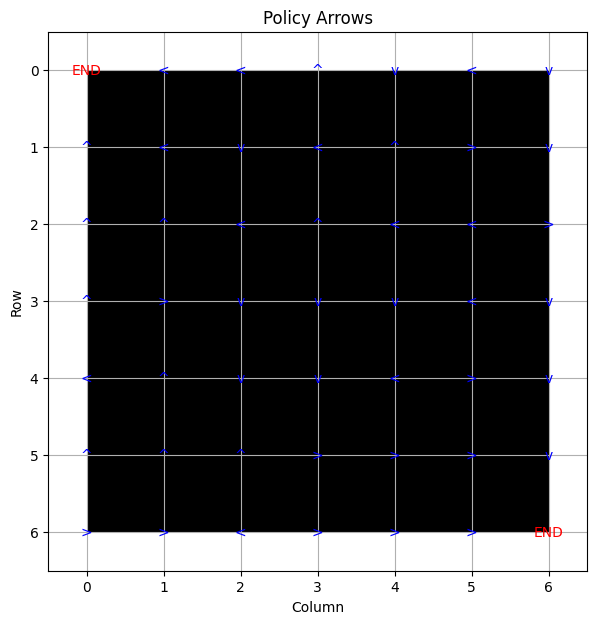

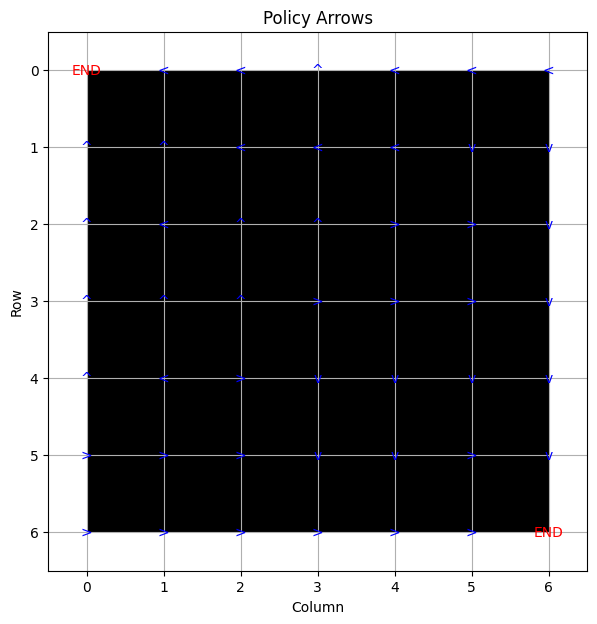

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

a,b,policy2=sarsa(alpha=0.45, epsilon=0.1)
a,b,policy=first_visit_mc_control()
import numpy as np


#rysowanie polityki dla sprawdzenia
def plot_policy_arrows(policy, end, start=start):
    plt.figure(figsize=(7, 7))
    plt.imshow(np.zeros((7, 7)), cmap='gray', vmin=0, vmax=1, origin='lower', extent=[0, 6, 0, 6])
    plt.grid(True)
    
    for i in range(7):
        for j in range(7):
            state = (i, j)
    
            if state in end:
                plt.text(j, i, 'END', color='red', ha='center', va='center', fontsize=10)
                continue
    
            best_action = max(policy[state], key=policy[state].get)
            arrows = {
                'UP': '^',
                'DOWN': 'v',
                'LEFT': '<',
                'RIGHT': '>'
            }
    
            plt.text(j, i, arrows[best_action], color='blue', ha='center', va='center', fontsize=10)
    
    plt.xlim(-0.5, 6.5)
    plt.ylim(-0.5, 6.5)
    plt.gca().invert_yaxis()  # Odwrócenie osi y dla lepszego zrozumienia siatki
    plt.title("Policy Arrows")
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.show()


plot_policy_arrows(policy=policy, end=end)
plot_policy_arrows(policy=policy2, end=end)

ogólnie to nie wiem, czemu tak wolno zbiega Sarsa - polityka końcowa wydaje się dobra, alphy inne też próbowałam dać i było tylko gorzej, te w zakresie (0.12,0.3) wypadały najlepiej. Za to polityka wyznaczona przez mc nie do końca jest dobra. Spróbuję przejść dokładniej po dużej ilości wartości alpha i epsilon i zobaczyć, dla jakich sarsa zbiega najszybciej.

In [ ]:
epsilons = np.linspace(0.01, 0.3, 4)
alphas = np.linspace(0.01, 0.5,12)
results=[]

for epsilon in epsilons:
    for alpha in alphas:
        avg_nr=0
        avg_r=0
        for i in range(10):
            ep, r, p=sarsa(alpha=alpha, epsilon=epsilon)
            avg_nr+=ep
            avg_r+=r
        results.append((epsilon, alpha, avg_nr/10, avg_r/avg_nr))


In [ ]:
best = min(results, key=lambda x: x[2])
best

najlepsze: eps=0.01, alpha=0.46 

In [6]:
avg_ep_mc=0
reward1=0
avg_ep_sarsa_a=0
reward2=0
avg_ep_sarsa_a2=0
reward3=0
avg_ep_sarsa_a3=0
reward4=0
for i in range(10):
    ep1, Q1, p=first_visit_mc_control()
    avg_ep_mc+=ep1
    reward1+=Q1
    ep2, Q2,p=sarsa(alpha=0.46, epsilon=0.01)
    avg_ep_sarsa_a+=ep2
    reward2+=Q2
    ep3, Q3,p=sarsa(alpha=0.15, epsilon=0.01)
    avg_ep_sarsa_a2+=ep3
    reward3+=Q3
    ep4, Q4,p=sarsa(alpha=0.27, epsilon=0.05)
    avg_ep_sarsa_a3+=ep4
    reward4+=Q4


print(f"Average number of episodes for Monte Carlo: {avg_ep_mc/10},  avg reward in 1 episode: {reward1/(avg_ep_mc)}")
print(f"Average number of episodes for SARSA (alpha=0.46, eps=0.01): {avg_ep_sarsa_a/10}, avg reward in 1 episode: {reward2/(avg_ep_sarsa_a)}")
print(f"Average number of episodes for SARSA (alpha=0.15, eps=0.01): {avg_ep_sarsa_a2/10}, avg reward in 1 episode: {reward3/(avg_ep_sarsa_a2)}")
print(f"Average number of episodes for SARSA (alpha=0.27, eps=0.05): {avg_ep_sarsa_a3/10}, avg reward in 1 episode: {reward4/(avg_ep_sarsa_a3)}")

Average number of episodes for Monte Carlo: 320.7,  avg reward in 1 episode: -9.396320548799501
Average number of episodes for SARSA (alpha=0.46, eps=0.01): 1686.4, avg reward in 1 episode: -4.143738140417457
Average number of episodes for SARSA (alpha=0.15, eps=0.01): 2862.3, avg reward in 1 episode: -4.597351780037033
Average number of episodes for SARSA (alpha=0.27, eps=0.05): 3096.6, avg reward in 1 episode: -4.247949363818382


Algorytm Sarsa dużo wolniej zbieżny, ale za to dokładniejszy lepsza nagroda, bo w mc polityka finalna nie do końca dobra (nie jest najgorsza, ale mogłaby być lepsza). Nie wiem, czy coś źle napisałam, czy to możliwe, że tak jest, ale już długo próbowałam naprawić i nie działało:)